# Escolhendo modelos

Dentre uma variedade gigante de modelos, vamos focar em 3: K-Nearest Neighbours (KNN), Suppport Vector Machines (SVM) e Long-short Term Memory Neural Networks (LSTM). As duas primeiras possuem diversas implementações no SkLearn, enquanto que a terceira pode ser usada com o PyTorch. 

Primeiro, vamos criar alguns dados dummy para podermos entender e visualizar o funcionamento dos algoritmos. Abaixo, temos um conjunto de dados com 500 amostras, duas dimensões (características) e três centros (classes).

Aumentando o desvio padrão (**cluster_std**) permite que os clusters fiquem mais esparsos, gerando intersecções entre elas. Vamos usar apenas duas características (**n_feats**) para podermos visualizar o problema.

In [1]:
import numpy as np
import pandas as pd
import gensim
from context import fakenews
from fakenews import preprocess as pre

In [50]:
from sklearn.datasets import make_blobs

dummyfeats, dummylbl = make_blobs(n_features=2, n_samples=2000, centers=3, cluster_std=3)

Os dados gerados serão diferentes a cada execução, mas **cluster_std=3** já é o suficiente para garantir alguma interseção entre as amostras. Acima disso já comça a virar bagunça!

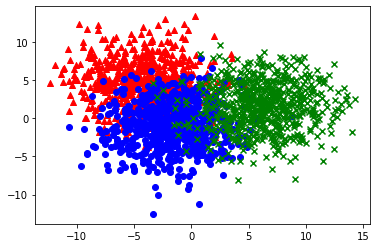

In [51]:
import matplotlib.pyplot as plt

def plot_data(data, lbls):
    c1 = data[lbls == 0]
    c2 = data[lbls == 1]
    c3 = data[lbls == 2]
    plt.scatter(c1[:, 0], c1[:, 1], marker='^', color='red')
    plt.scatter(c2[:, 0], c2[:, 1], marker='o', color='blue')
    plt.scatter(c3[:, 0], c3[:, 1], marker='x', color='green')
plot_data(dummyfeats, dummylbl)

Agora, precisamos dividir os dados em treino e teste. Poderíamos também adicionar um terceiro subconjunto **validação**, mas futuramente usaremos validação cruzada. Lembrando que, a **validação cruzada** permite simular o conjunto de validação quando não temos dados suficientes.

Vamos usar, novamente, o SkLearn para isso. O método abaixo possui várias customizações permitindo sua aplicação em diferentes cenários. Abaixo, a separação mais simples consiste em apenas escolher o tamanho do conjunto de teste (**test_size**)

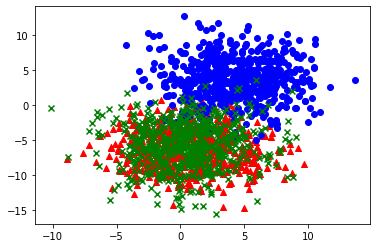

In [4]:
from sklearn.model_selection import train_test_split

dummysplits = train_test_split(dummyfeats, dummylbl, test_size=0.1)
dummy_ftrain, dummy_ftest, dummylbl_train, dummylbl_test = dummysplits

plot_data(dummy_ftrain, dummylbl_train)

Em alguns casos, principalmente em problemas de identificação, pode ser necessário garantir que todas as classes estejam presentes em ambos os conjuntos. Podemos usar a separação estratificada (**stratify**), mantendo as proporções dos dados de acordo com alguma característica da base.

In [5]:
dummysplits = train_test_split(dummyfeats, dummylbl, test_size=0.3, stratify=dummylbl)
dummy_ftrain, dummy_ftest, dummylbl_train, dummylbl_test = dummysplits

Por fim, para evitar que seus experimentos sejam tendenciados por ter escolhido um ponto muito no espaço de busca (ou muito ruim) também podemos embaralhar as amostras (**shuffle**). No entanto, acaba sendo desnecessário quando usamos validação cruzada.

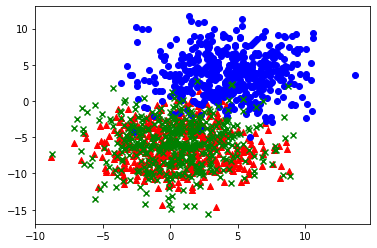

In [6]:
dummysplits = train_test_split(dummyfeats, dummylbl, test_size=0.3, stratify=dummylbl, shuffle=True)
dummy_ftrain, dummy_ftest, dummylbl_train, dummylbl_test = dummysplits

plot_data(dummy_ftrain, dummylbl_train)

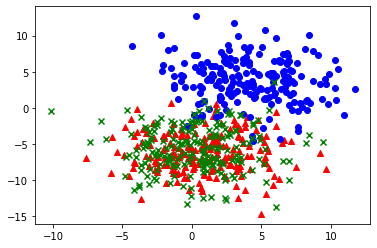

In [7]:
plot_data(dummy_ftest, dummylbl_test)

Com os dados devidamente separados, podemos aplicar ao nosso modelo para treinamento e teste. Vamos usar o KNN para exemplificar o procedimento, e mais na frente fazemos o mesmo de forma resumida para o SVM e o LSTM. Na maioria dos casos, os modelos do SkLearn fazem o treinamento a partir do método **fit**, o teste com o **predict**, os dois com o **fit_predict**, ou também podemos usar o **score** para calcular alguma métrica sobre a predição. 

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(dummy_ftrain, dummylbl_train)
knn.score(dummy_ftest, dummylbl_test)

0.6566666666666666

Com esses métodos, temos um modelo decente para classificar nossos dados. Mas ainda podemos ir além, pois o knn está usando apenas valores padrões. Embora sejam valores comuns, **não são os melhores!**. Vejamos quantos parâmetros o modelo posssui

In [9]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Temos um total de 8 parâmetros que podem ser ajustados no nosso modelo! Dentre eles, **p**, **n_neighbors** e **weights** podem afetar nossa performance. Vamos aumentar a quantidade de vizinhos e ver qual o efeito disso

In [10]:
knn.set_params(n_neighbors=7)
knn.score(dummy_ftest, dummylbl_test)

0.64

E que tal reduzir pra 1?

In [11]:
knn.set_params(n_neighbors=1)
knn.score(dummy_ftest, dummylbl_test)

0.64

E pra 200?

In [12]:
knn.set_params(n_neighbors=200)
knn.score(dummy_ftest, dummylbl_test)

0.66

Otimizar os parâmetros assim é bastante trabalhoso e aumenta substancialmente a probabilidade de errarmos ou esquecer alguma coisa no caminho. Para evitar isso, podemos automatizar nossa busca pelo modelo _"ótimo"_ para o nosso problema. Vamos usar uma forma mais simples e ordenada para otmização dos parâmetros: **Grid Search**.

Isso é literalmente criar uma malha (ou uma matriz, se preferir) onde podemos ver cada coluna como valores de parâmetros a serem otimizados, sendo assim as linhas as combinações entre esses parâmetros. Por exemplo, para o knn

In [13]:
from sklearn.model_selection import GridSearchCV

pgrid = [{'n_neighbors': [5, 10, 15, 20], 'p': [1, 2, 3]}
         {'n_neighbors': [2, 4, 8, 16], 'metric': ['minkowski', 'manhattan']}]

estimator = KNeighborsClassifier()
gsearch = GridSearchCV(estimator, pgrid, cv=3)
gsearch.fit(dummy_ftrain, dummylbl_train)
cv_results = pd.DataFrame(gsearch.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000847,0.000058,0.021077,0.001628,5,1,"{'n_neighbors': 5, 'p': 1}",0.663812,0.659529,0.667382,0.663574,0.003210,10
1,0.000813,0.000055,0.019642,0.000904,5,2,"{'n_neighbors': 5, 'p': 2}",0.672377,0.655246,0.652361,0.659995,0.008835,11
2,0.000936,0.000103,0.023242,0.000455,5,3,"{'n_neighbors': 5, 'p': 3}",0.661670,0.635974,0.663090,0.653578,0.012461,12
3,0.001170,0.000499,0.021824,0.000402,10,1,"{'n_neighbors': 10, 'p': 1}",0.689507,0.676660,0.665236,0.677134,0.009914,3
4,0.000775,0.000061,0.019767,0.000739,10,2,"{'n_neighbors': 10, 'p': 2}",0.691649,0.668094,0.645923,0.668555,0.018670,8
5,0.000796,0.000035,0.022404,0.000259,10,3,"{'n_neighbors': 10, 'p': 3}",0.691649,0.668094,0.663090,0.674278,0.012452,5
6,0.000790,0.000021,0.020629,0.000564,15,1,"{'n_neighbors': 15, 'p': 1}",0.668094,0.665953,0.667382,0.667143,0.000890,9
7,0.000764,0.000005,0.019271,0.000131,15,2,"{'n_neighbors': 15, 'p': 2}",0.670236,0.672377,0.675966,0.672859,0.002364,6
8,0.000809,0.000021,0.022915,0.000526,15,3,"{'n_neighbors': 15, 'p': 3}",0.687366,0.683084,0.686695,0.685715,0.001881,1
9,0.000779,0.000006,0.020632,0.000313,20,1,"{'n_neighbors': 20, 'p': 1}",0.674518,0.683084,0.678112,0.678571,0.003512,2


O **pgrid** é justamente a matriz de combinações que queremos testar. Note que usamos o parâmetro **cv**, ele permite especificar qual tipo de validação cruzada queremos usar. No exemplo acima, optei por usar uma validação cruzada 3 estratificada.

Em seguida, visualizamos os resultados como um DataFrame. Mas o cv_results é um dicionário com várias informações sobre as execuções! Também podemos ver qual foi a melhor configuração, uma instância do melhor classficador,

In [14]:
print(f'Best conf: {gsearch.best_params_}')
gsearch.best_estimator_

Best conf: {'n_neighbors': 15, 'p': 3}


KNeighborsClassifier(n_neighbors=15, p=3)

Agora, com o nosso classificador bombado podemos usá-lo no conjunto de teste!

In [15]:
knn = gsearch.best_estimator_
knn.score(dummy_ftest, dummylbl_test)

0.655

Vamos visualizar os resultados de forma mais detalhada usando uma matriz de confusão

[[118   2 105]
 [  7 188   8]
 [ 75  10  87]]


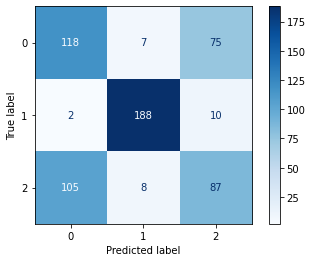

In [16]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

preds = knn.predict(dummy_ftest)
print(confusion_matrix(preds, dummylbl_test))
plot_confusion_matrix(knn, dummy_ftest, dummylbl_test, cmap='Blues')

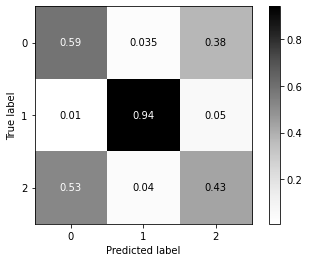

In [17]:
plot_confusion_matrix(knn, dummy_ftest, dummylbl_test, cmap='Greys', normalize='true')

Então, temos um modelo ótimo? Provavelmente não, a forma como o GS funciona nos permite verificar onde provavelmente está o nosso valor ótimo e daí podemos realizar uma nova busca dentro desse intervalo. Entretanto isso é muito custoso e entramos num looping infinito! Por exemplo, podemos verificar a acarácia do modelo de acordo com variações em `k`

In [18]:
manh = cv_results[cv_results['param_p'] == 1]
eucl = cv_results[cv_results['param_p'] == 2]
mink = cv_results[cv_results['param_p'] == 3]
mink

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,0.000936,0.000103,0.023242,0.000455,5,3,"{'n_neighbors': 5, 'p': 3}",0.661670,0.635974,0.663090,0.653578,0.012461,12
5,0.000796,0.000035,0.022404,0.000259,10,3,"{'n_neighbors': 10, 'p': 3}",0.691649,0.668094,0.663090,0.674278,0.012452,5
8,0.000809,0.000021,0.022915,0.000526,15,3,"{'n_neighbors': 15, 'p': 3}",0.687366,0.683084,0.686695,0.685715,0.001881,1
11,0.000821,0.000040,0.023506,0.000579,20,3,"{'n_neighbors': 20, 'p': 3}",0.672377,0.655246,0.684549,0.670724,0.012020,7


(0.5, 1.0)

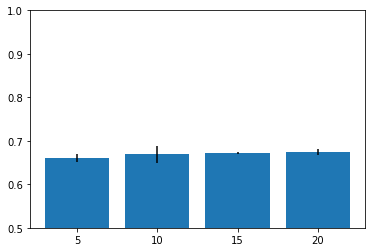

In [19]:
plt.bar(np.arange(4), eucl['mean_test_score'], tick_label=eucl['param_n_neighbors'], yerr=eucl['std_test_score'])
plt.ylim(.5, 1)

Como não há muita variação, isso indica que podemos aumentar o espaço de busca para o valor de `k`. Onde caso houve uma queda seguida de subida, indicaria o intervalo no qual uma nova busca pode ser realizada.

## Adicionano outros modelos para comparação

In [20]:
from sklearn.svm import SVC

svm = SVC()
pgrid = [{'kernel': ['rbf', 'sigmoid'], 'C':[0.01, 0.1, 1], 'gamma':[0.001, 0.01]},
         {'kernel': ['poly'], 'C':[0.01, 0.1, 1], 'gamma':[0.001, 0.01], 'degree':[2, 3]},]
gs_svm = GridSearchCV(svm, pgrid, cv=3)
gs_svm.fit(dummy_ftrain, dummylbl_train)
results = pd.DataFrame(gs_svm.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,param_degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.026496,0.001036,0.007936,0.001310,0.01,0.001,rbf,NaN,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}",0.653105,0.695931,0.650215,0.666417,0.020903,7
1,0.030070,0.000096,0.009299,0.000034,0.01,0.001,sigmoid,NaN,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'sigmoid'}",0.653105,0.693790,0.650215,0.665703,0.019895,8
2,0.018447,0.000173,0.005847,0.000256,0.01,0.01,rbf,NaN,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}",0.653105,0.685225,0.650215,0.662848,0.015867,9
3,0.030753,0.000107,0.011804,0.000064,0.01,0.01,sigmoid,NaN,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.650964,0.659529,0.650215,0.653569,0.004225,12
4,0.015862,0.000251,0.005330,0.000098,0.1,0.001,rbf,NaN,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.653105,0.700214,0.650215,0.667845,0.022919,4


In [21]:
bestsvm = gs_svm.best_estimator_
gs_svm.best_params_

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

In [22]:
bestsvm.score(dummy_ftest, dummylbl_test)

0.655

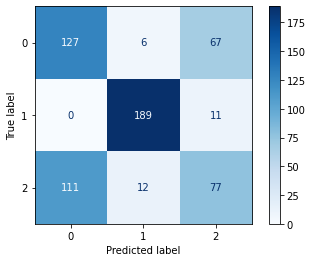

In [23]:
plot_confusion_matrix(bestsvm, dummy_ftest, dummylbl_test, cmap='Blues')

In [24]:
from sklearn.metrics import f1_score, make_scorer


scorer = make_scorer(f1_score, average='macro')
f1gs_svm = GridSearchCV(svm, pgrid, cv=3, scoring=scorer)
f1gs_svm.fit(dummy_ftrain, dummylbl_train)
results = pd.DataFrame(f1gs_svm.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,param_degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.023650,0.001644,0.007900,0.001496,0.01,0.001,rbf,NaN,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}",0.636009,0.691990,0.541040,0.623013,0.062306,8
1,0.031058,0.001111,0.010099,0.000408,0.01,0.001,sigmoid,NaN,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'sigmoid'}",0.636348,0.689848,0.540481,0.622226,0.061791,9
2,0.018022,0.000190,0.006294,0.000157,0.01,0.01,rbf,NaN,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}",0.634774,0.680330,0.542467,0.619190,0.057351,10
3,0.030614,0.000203,0.012434,0.000236,0.01,0.01,sigmoid,NaN,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.608960,0.613814,0.542467,0.588414,0.032550,12
4,0.015381,0.000093,0.006145,0.000320,0.1,0.001,rbf,NaN,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.636511,0.697104,0.542467,0.625361,0.063621,7


In [25]:
bestf1_svm = f1gs_svm.best_estimator_
f1gs_svm.best_params_

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

In [26]:
preds = bestf1_svm.predict(dummy_ftest)
f1_score(preds, dummylbl_test, average='macro')

0.644005635742157

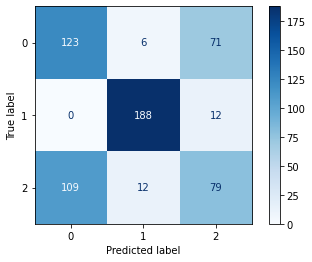

In [27]:
plot_confusion_matrix(bestf1_svm, dummy_ftest, dummylbl_test, cmap='Blues')

In [28]:
rbfresults = results[results['param_kernel'] == 'sigmoid']
rbfresults_gamma = rbfresults[rbfresults['param_gamma'] == 0.01]
rbfresults_gamma

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,param_degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.030614,0.000203,0.012434,0.000236,0.01,0.01,sigmoid,NaN,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.60896,0.613814,0.542467,0.588414,0.032550,12
7,0.020274,0.000238,0.010816,0.000422,0.1,0.01,sigmoid,NaN,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.60896,0.609991,0.635841,0.618264,0.012436,11
11,0.016649,0.000604,0.008859,0.000188,1,0.01,sigmoid,NaN,"{'C': 1, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.64016,0.665634,0.648076,0.651290,0.010645,5


(0.5, 1.0)

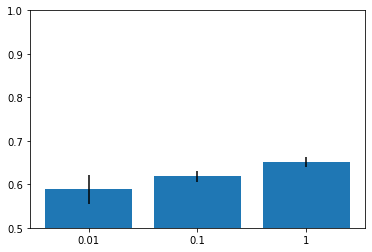

In [29]:
plt.bar(np.arange(3), 
        rbfresults_gamma['mean_test_score'],
        tick_label=rbfresults_gamma['param_C'],
        yerr=rbfresults_gamma['std_test_score'])

plt.ylim(.5, 1)

Nesse caso podemos visualizar que ao aumentar `C` de 0.1 para 1, com $\gamma = 0.01$, a acurácia reduz consecutivamente. Isso indica que o ótimo deve estar entre os valores 0.01 e 0.1. Dessa forma, caso queiramos otimizar ainda mais o modelo, poderíamos expandir o intervalo de $C$ para $C\in[0.01, 0.03, 0.05, 0.07, 0.09, 0.1]$ e repetir o processo quantas vezes for necessário.

### Randomized Search

Também podemos usar outras técnicas de otimização como a busca **aleatória** e em **árvore**. Ao contrário  do GS, a busca aleatória usa distribuições ao invés de valores fixos. O SkLearn não disponibiliza uma classe para busca em árvore, mas tendo em vista que isso é nada mais que um backpropagation com prunning, podemos usar de outras bibliotecas.

Para gerar as distribuições, o módulo ´stats´ do scipy oferece: exponencial, uniforme, gamma e outras.

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon

rnd_space = [{'kernel': ['rbf'], 'C':expon(scale=10), 'gamma':expon(scale=.1)}]
rnds_svm = RandomizedSearchCV(SVC(), rnd_space, cv=3)
rnds_svm.fit(dummy_ftrain, dummylbl_train)
results = pd.DataFrame(rnds_svm.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011892,0.000435,0.004290,0.000036,9.16017,0.0109188,rbf,"{'C': 9.160173074751187, 'gamma': 0.0109188264...",0.661670,0.663812,0.682403,0.669295,0.009310,6
1,0.021115,0.001824,0.004722,0.000398,2.68206,0.242448,rbf,"{'C': 2.682061841159924, 'gamma': 0.2424477939...",0.678801,0.672377,0.693133,0.681437,0.008676,2
2,0.025871,0.000634,0.004728,0.000464,17.2379,0.342007,rbf,"{'C': 17.23788918015643, 'gamma': 0.3420069568...",0.665953,0.676660,0.678112,0.673575,0.005422,3
3,0.010383,0.000496,0.004352,0.000102,0.795706,0.0141918,rbf,"{'C': 0.7957058110208047, 'gamma': 0.014191765...",0.653105,0.687366,0.667382,0.669284,0.014052,7
4,0.012514,0.000882,0.004155,0.000117,10.4541,0.0154449,rbf,"{'C': 10.454133137253326, 'gamma': 0.015444892...",0.678801,0.646681,0.686695,0.670726,0.017305,4


In [31]:
bestrnd_svm = rnds_svm.best_estimator_
rnds_svm.best_params_

{'C': 4.574059832809054, 'gamma': 0.2374996187022077, 'kernel': 'rbf'}

In [32]:
bestrnd_svm.score(dummy_ftest, dummylbl_test)

0.66

Note que agora os parâmetros estão numa escala bem diferente comparadas ao GridSearch! Outra parte importante sobre o randomized é a quantidade de amostras, por padrão são usadas 10 amostras das distribuições, mas podemos alterar isso usando com o `n_iter=30`

In [33]:
rnd_space = [{'kernel': ['rbf'], 'C':expon(scale=10), 'gamma':expon(scale=.1)}]
rnds_svm = RandomizedSearchCV(SVC(), rnd_space, cv=3, n_iter=30)
rnds_svm.fit(dummy_ftrain, dummylbl_train)
results = pd.DataFrame(rnds_svm.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011225,0.000321,0.004270,0.000195,3.09222,0.0209941,rbf,"{'C': 3.0922233934516683, 'gamma': 0.020994077...",0.676660,0.653105,0.684549,0.671438,0.013358,17
1,0.010416,0.000513,0.004544,0.000595,5.24566,0.00558777,rbf,"{'C': 5.245664372444945, 'gamma': 0.0055877678...",0.650964,0.695931,0.675966,0.674287,0.018396,9
2,0.023946,0.000827,0.005413,0.000951,3.95858,0.346486,rbf,"{'C': 3.958580621918257, 'gamma': 0.3464857290...",0.695931,0.676660,0.675966,0.682852,0.009253,3
3,0.014981,0.000247,0.004614,0.000138,0.347054,0.121677,rbf,"{'C': 0.34705358370436246, 'gamma': 0.12167721...",0.670236,0.678801,0.673820,0.674285,0.003512,10
4,0.011882,0.000460,0.004334,0.000101,0.493985,0.0471306,rbf,"{'C': 0.4939854192517637, 'gamma': 0.047130605...",0.683084,0.655246,0.680258,0.672862,0.012510,11


In [34]:
bestrnd_svm = rnds_svm.best_estimator_
rnds_svm.best_params_

{'C': 6.028381965951657, 'gamma': 0.16516382921482411, 'kernel': 'rbf'}

In [35]:
bestrnd_svm.score(dummy_ftest, dummylbl_test)

0.6583333333333333

### Aplicando as fakenews

Vamos carregar os dados e aplicar os passos do preprocessamento novamente (sim, eu esqueci de salvar a base). Mas ainda precisamos fazer mais alguns passos antes de aplicar aos modelos.

In [36]:
base = '/home/thalesaguiar/Dev/FakeNews/'
news, labels = pre.run(base + 'data/Fake.csv', base + 'data/True.csv')
print(news[0][:10])

Succesfully read data from:
Fakes: /home/thalesaguiar/Dev/FakeNews/data/Fake.csv
Reals: /home/thalesaguiar/Dev/FakeNews/data/True.csv
Removing rows without text...
Removing publisher information...
Adding class column...
Merging fakes and reals
Merging titles and bodies...
Removing subjects and date...
Tokenizing data...
['donald', 'trump', 'sends', 'embarrassing', 'new', 'year', 'eve', 'message', 'disturbing', 'donald']


In [37]:
pre.truncate_news(news)

Truncating at 869


Vamos novamente, mais uma vez, carregar nosso modelo w2v na memória. Entretanto, o que o w2v modela?

In [44]:
w2v = gensim.models.Word2Vec.load('fakenews-w2v.model')

In [45]:
news[0][:10]

['donald',
 'trump',
 'sends',
 'embarrassing',
 'new',
 'year',
 'eve',
 'message',
 'disturbing',
 'donald']

O w2v está modelando cada palavra, entretanto estamos tentando identificar se o DOCUMENTO (new) é fake ou não. Então, precisamos ajustar as features, ou a forma de predição dos classificadores. No caso das features

In [46]:
splits = train_test_split(news, labels, test_size=0.3, shuffle=True)
news_trn, news_tst, labels_trn, labels_tst = splits

trn_vecs = []
for new in news_trn:
    vecs = w2v.wv[new]
    meanvec = np.mean(vecs, axis=0)
    trn_vecs.append(meanvec)

trn_vecs = np.array(trn_vecs)
    
tst_vecs = []
for new in news_tst:
    vecs = w2v.wv[new]
    meanvec = np.mean(vecs, axis=0)
    tst_vecs.append(meanvec)

tst_vecs = np.array(tst_vecs)

In [47]:
print(f'Training data shape: {trn_vecs.shape}')
print(f'Test data shape: {tst_vecs.shape}')

Training data shape: (30986, 100)
Test data shape: (13281, 100)


In [48]:
models = [KNeighborsClassifier(), SVC()]
pgrids = [
    {'n_neighbors': [4, 8, 16], 'p': [2, 3]},
    [{'kernel': ['rbf', 'sigmoid'], 'C': [0.01, 0.1, 1], 'gamma': [0.001, 0.01]},
     {'kernel': ['poly'], 'C': [0.01, 0.1, 1], 'gamma': [0.001, 0.01], 'degree': [2, 3]}]
]

In [49]:
best_models = []
for model, grid in zip(models, pgrids):
    optimizer = GridSearchCV(model, grid, cv=3)
    optimizer.fit(trn_vecs, labels_trn)
    print(optimizer.best_estimator_)
    best_models.append(optimizer.best_estimator_)

best_models

KNeighborsClassifier(n_neighbors=16, p=3)


KeyboardInterrupt: 

Quanto a alterar a forma de predição, precisamos expandir os rótulos. Essa expansão adiciona um label para cada palavra onde esse label corresponde ao label do notícia. Desa forma, para o knn, vamos predizer para cada palvra e usar a classe mais frequente como resultado final. Para o SVM, podemos fazer algo semelhante.